<a href="https://colab.research.google.com/github/maddali-bansi/Tensorflow-NLP/blob/master/BBC_Archive_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Bansi Maddali <br>
Github : https://github.com/maddali-bansi/Tensorflow-NLP <br>
Dataset Source : https://www.kaggle.com/yufengdev/bbc-fulltext-and-category

1.Problem Description

---
We have the BBC news dataset , which has two columns.One for the actual article and other for the type of the category.<br>Our target is to build a NLP Model which will input the article and give its respective category.



2.Problem Approach

---
We build the network using Keras layers of Embedding and Bi-Directional LSTM.


3.Data Processing

---






In [ ]:
#Get the cleaned up data 
!wget --no-check-certificate https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv -O bbc-text.csv

--2021-02-04 13:03:35--  https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘bbc-text.csv’

bbc-text.csv        100%[===================>]   4.82M  --.-KB/s    in 0.04s   

2021-02-04 13:03:35 (114 MB/s) - ‘bbc-text.csv’ saved [5057493/5057493]



In [ ]:
#Examine the Data in the file
import csv
with open('bbc-text.csv') as csvfile:
  csv_reader = csv.reader(csvfile,delimiter=',')
  preview_lines = 2
  for row in csv_reader:
    print(row)
    preview_lines = preview_lines - 1
    if(preview_lines==0):
      break

['category', 'text']
['tech', 'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they a

In [ ]:
#Clean the Stopwords ,  We use NLTK library to filter the stop words in sentences.
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

#Segregate Labels and Sentences
labels = []
articles = []

import csv
with open('bbc-text.csv') as csvfile:
  csv_reader = csv.reader(csvfile,delimiter=',')

  #skip the first row as they are column names
  next(csv_reader)
  
  for row in csv_reader:
    labels.append(row[0])
    
    article = row[1]
    for stopword in stopwords.words('english'):
      stopword = " "+stopword+" " # As space is also a character string
      article = article.replace(stopword, " ") # Preserve space between pre and post words of stopwords
      article = article.replace("  ", " ") # Convert double spacing to single spacing if any
    articles.append(article)


print('Total Number of Lables',len(labels))
print('Total Number of Articles',len(articles))
print("Article : " ,articles[0])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Total Number of Lables 2225
Total Number of Articles 2225
Article :  tv future hands viewers home theatre systems plasma high-definition tvs digital video recorders moving living room way people watch tv radically different five years time. according expert panel gathered annual consumer electronics show las vegas discuss new technologies impact one favourite pastimes. us leading trend programmes content delivered viewers via home networks cable satellite telecoms companies broadband service providers front rooms portable devices. one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes like us tivo uk sky+ system allow people record store play pause forward wind tv programmes want. essentially technology allows much personalised tv. also built-in high-definition tv sets big business japan us slower take europe lack high-definition pr

In [ ]:
print("Total Classes = ",set(labels))

Total Classes =  {'entertainment', 'business', 'tech', 'sport', 'politics'}


4.Generate Tokens and Sequences

---

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocabulary_size = 10000
embedding_dim = 64
max_length_article = 200
trunc_type = 'post'
padding_type='post'
oov_token = '<OOV>'

In [ ]:
train_size = int(0.8*len(labels))
train_labels = labels[0:train_size] 
train_articles = articles[0:train_size]
test_labels = labels[train_size:]
test_articles = articles[train_size:]

In [ ]:
bbc_tokenizer = Tokenizer(num_words=vocabulary_size, oov_token=oov_token)

In [ ]:
bbc_tokenizer.fit_on_texts(train_articles)
word_index = bbc_tokenizer.word_index
print(len(word_index))

27270


In [ ]:
import numpy as np
train_sequences = bbc_tokenizer.texts_to_sequences(train_articles)
train_padded = np.array(pad_sequences(train_sequences,maxlen=max_length_article, padding=padding_type, truncating=trunc_type))

In [ ]:
test_sequences = bbc_tokenizer.texts_to_sequences(test_articles)
test_padded = np.array(pad_sequences(test_sequences,maxlen=max_length_article, padding=padding_type, truncating=trunc_type))

In [ ]:
import numpy as np
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
test_label_seq = np.array(label_tokenizer.texts_to_sequences(test_labels))

In [ ]:
label_tokenizer.word_index

{'business': 2, 'entertainment': 5, 'politics': 3, 'sport': 1, 'tech': 4}

5.Build the Network

___

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Bidirectional,GlobalAveragePooling1D,Dropout
import tensorflow as tf
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(6, activation='softmax'))
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 706,822
Trainable params: 706,822
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(test_padded, test_label_seq), verbose=1)

Epoch 1/10
56/56 [==============================] - 10s 38ms/step - loss: 1.6865 - accuracy: 0.2661 - val_loss: 1.2667 - val_accuracy: 0.4112
Epoch 2/10
56/56 [==============================] - 1s 26ms/step - loss: 1.2005 - accuracy: 0.4825 - val_loss: 0.9289 - val_accuracy: 0.6764
Epoch 3/10
56/56 [==============================] - 1s 25ms/step - loss: 0.9216 - accuracy: 0.6285 - val_loss: 0.7507 - val_accuracy: 0.7798
Epoch 4/10
56/56 [==============================] - 1s 25ms/step - loss: 0.4450 - accuracy: 0.9153 - val_loss: 0.3861 - val_accuracy: 0.9034
Epoch 5/10
56/56 [==============================] - 1s 26ms/step - loss: 0.1724 - accuracy: 0.9683 - val_loss: 0.2833 - val_accuracy: 0.9124
Epoch 6/10
56/56 [==============================] - 1s 26ms/step - loss: 0.0961 - accuracy: 0.9810 - val_loss: 0.2675 - val_accuracy: 0.9348
Epoch 7/10
56/56 [==============================] - 1s 26ms/step - loss: 0.0620 - accuracy: 0.9942 - val_loss: 0.2136 - val_accuracy: 0.9371
Epoch 8/10
5

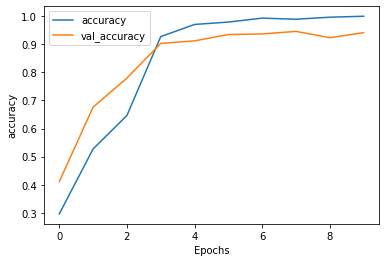

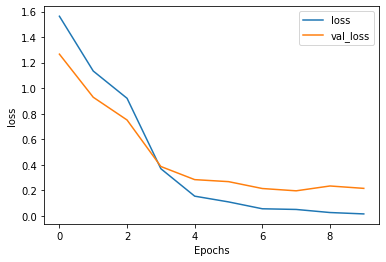

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

6.Testing

___

In [ ]:
#txt = ["blair prepares to name poll date tony blair is likely to name 5 may as election day when parliament returns from its easter break  the bbc s political editor has learned.  andrew marr says mr blair will ask the queen on 4 or 5 april to dissolve parliament at the end of that week. mr blair has so far resisted calls for him to name the day but all parties have stepped up campaigning recently. downing street would not be drawn on the claim  saying election timing was a matter for the prime minister.  a number 10 spokeswoman would only say:  he will announce an election when he wants to announce an election.  the move will signal a frantic week at westminster as the government is likely to try to get key legislation through parliament. the government needs its finance bill  covering the budget plans  to be passed before the commons closes for business at the end of the session on 7 april.  but it will also seek to push through its serious and organised crime bill and id cards bill. mr marr said on wednesday s today programme:  there s almost nobody at a senior level inside the government or in parliament itself who doesn t expect the election to be called on 4 or 5 april.  as soon as the commons is back after the short easter recess  tony blair whips up to the palace  asks the queen to dissolve parliament ... and we re going.  the labour government officially has until june 2006 to hold general election  but in recent years governments have favoured four-year terms."]
#txt = ["Miraz rallied well with the other lower-order batsmen, nearly all of whom managed to score in double digits and the last five batsmen went on to add 237 runs, more than what the top five batters had made for the team."]
#txt = ["Miraz rallied well with the other lower-order batsmen, nearly all of whom managed to score in double digits and the last five batsmen went on to add 237 runs, more than what the top five batters had made for the team.After that the new-ball burst from pacer Mustafizur Rahman, who removed opener John Campbell and debutant Shayne Moseley to have the visitors stuttering at 24-2, made sure that it was advantage Bangladesh on Day 2 of the Chattogram Test as they lead West Indies by 355 runs."]
#txt = ["Sources tell CBS Sports that top-ranked Gonzaga is trying to secure a game against a quality opponent for this weekend. A matchup against No. 5 Houston -- to be played in Salt Lake City -- came close to happening, but a source said that the agreement fell through on Monday. (Houston has no scheduled game this weekend; it's a mighty attractive opponent for Mark Few's Bulldogs.) The chase for GU remains, and a source shared one additional team of interest, though it's not a candidate as of today because it has no scheduled openings. If you're curious as to whether or not this mystery team is Baylor, a spoiler: it's not. The Big 12 just had its inter-conference series against the SEC last weekend and has instructed its members that it doesn't want any of them trying to improvise with any games this late in the season against opponents outside conference borders."]
txt = ["Basketball, colloquially referred to as hoops,[1] is a team sport in which two teams, most commonly of five players each, opposing one another on a rectangular court, compete with the primary objective of shooting a basketball (approximately 9.4 inches (24 cm) in diameter) through the defender's hoop (a basket 18 inches (46 cm) in diameter mounted 10 feet (3.048 m) high to a backboard at each end of the court) while preventing the opposing team from shooting through their own hoop. A field goal is worth two points, unless made from behind the three-point line, when it is worth three. After a foul, timed play stops and the player fouled or designated to shoot a technical foul is given one, two or three one-point free throws. The team with the most points at the end of the game wins, but if regulation play expires with the score tied, an additional period of play (overtime) is mandated.Players advance the ball by bouncing it while walking or running (dribbling) or by passing it to a teammate, both of which require considerable skill. On offense, players may use a variety of shots—the lay-up, the jump shot, or a dunk; on defense, they may steal the ball from a dribbler, intercept passes, or block shots; either offense or defense may collect a rebound, that is, a missed shot that bounces from rim or backboard. It is a violation to lift or drag one's pivot foot without dribbling the ball, to carry it, or to hold the ball with both hands then resume dribbling.The five players on each side fall into five playing positions. The tallest player is usually the center, the second-tallest and strongest is the power forward, a slightly shorter but more agile player is the small forward, and the shortest players or the best ball handlers are the shooting guard and the point guard, who implements the coach's game plan by managing the execution of offensive and defensive plays (player positioning). Informally, players may play three-on-three, two-on-two, and one-on-one.Invented in 1891 by Canadian-American gym teacher James Naismith in Springfield, Massachusetts, United States, basketball has evolved to become one of the world's most popular and widely viewed sports.[2] The National Basketball Association (NBA) is the most significant professional basketball league in the world in terms of popularity, salaries, talent, and level of competition.[3][4] Outside North America, the top clubs from national leagues qualify to continental championships such as the EuroLeague and the Basketball Champions League Americas. The FIBA Basketball World Cup and Mens Olympic Basketball Tournament are the major international events of the sport and attract top national teams from around the world. Each continent hosts regional competitions for national teams, like EuroBasket and FIBA AmeriCup."]
seq = bbc_tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length_article)
pred = model.predict(padded)
#{'business': 2, 'entertainment': 5, 'politics': 3, 'sport': 1, 'tech': 4}
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment'] 
print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)-1])

[[0.00096282 0.8572391  0.02492874 0.04591267 0.02413679 0.04681986]]
1
sport
